In [130]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier


In [131]:
churn_df = pd.read_csv('churn.csv')
churn_df.head(), churn_df.describe(), churn_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


(   RowNumber  CustomerId   Surname  CreditScore Geography  Gender   Age  \
 0          1    15634602  Hargrave          619    France  Female  42.0   
 1          2    15647311      Hill          608     Spain  Female  41.0   
 2          3    15619304      Onio          502    France  Female  42.0   
 3          4    15701354      Boni          699    France  Female  39.0   
 4          5    15737888  Mitchell          850     Spain  Female  43.0   
 
    Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
 0       2       0.00              1        1.0             1.0   
 1       1   83807.86              1        0.0             1.0   
 2       8  159660.80              3        1.0             0.0   
 3       1       0.00              2        0.0             0.0   
 4       2  125510.82              1        NaN             1.0   
 
    EstimatedSalary  Exited  
 0        101348.88       1  
 1        112542.58       0  
 2        113931.57       1  
 3         93826.6

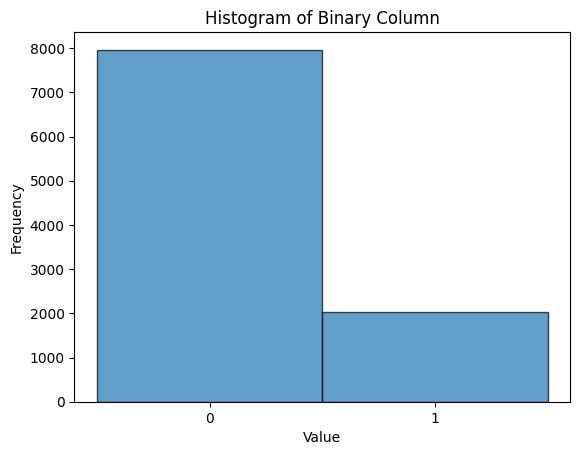

In [132]:
unique_values = churn_df['Exited'].unique()
bins = np.arange(len(unique_values) + 1) - 0.5
plt.hist(churn_df['Exited'], bins=bins, edgecolor='black', alpha=0.7)
plt.xticks(unique_values)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Binary Column')
plt.show()

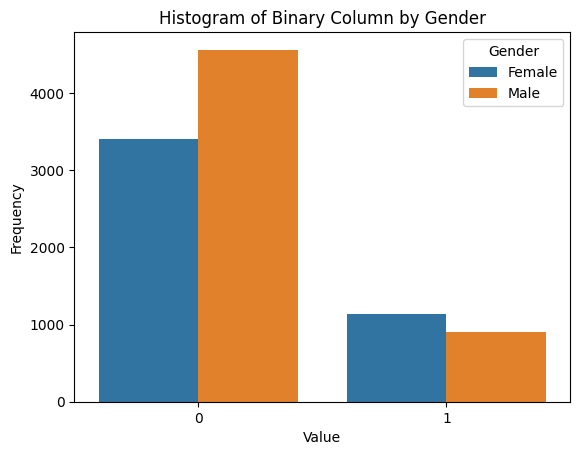

In [133]:
sns.countplot(data=churn_df, x='Exited', hue='Gender')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Binary Column by Gender')
plt.show()


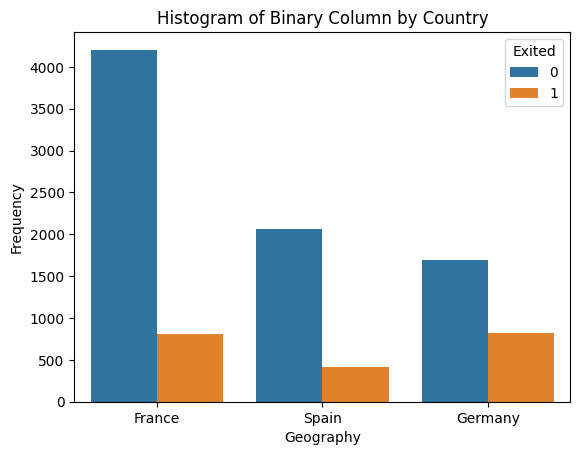

In [134]:
sns.countplot(data=churn_df, x='Geography', hue='Exited')
plt.ylabel('Frequency')
plt.title('Histogram of Binary Column by Country')
plt.show()


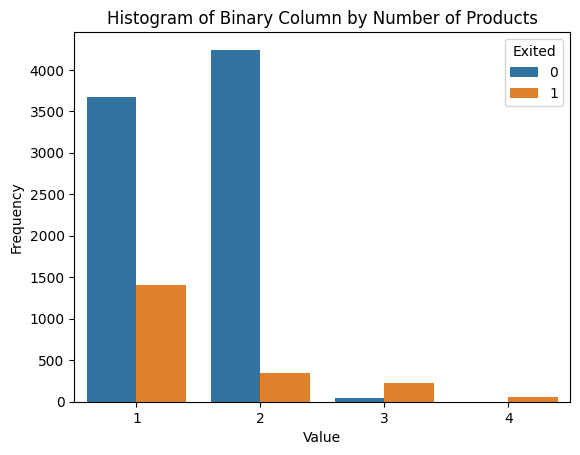

In [135]:
sns.countplot(data=churn_df, x='NumOfProducts', hue='Exited')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Binary Column by Number of Products')
plt.show()

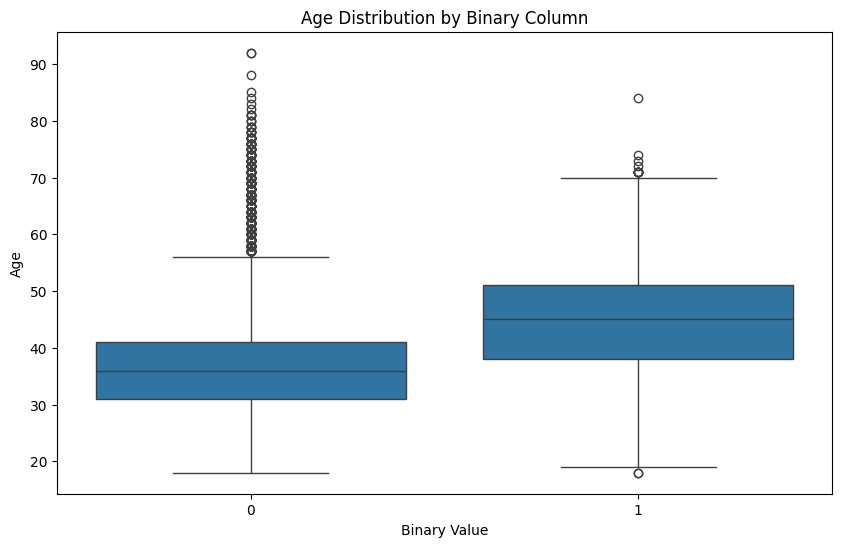

In [136]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=churn_df, x='Exited', y='Age')
plt.xlabel('Binary Value')
plt.ylabel('Age')
plt.title('Age Distribution by Binary Column')
plt.show()

In [137]:
churn_df.drop(['RowNumber','Surname','CustomerId'], axis=1, inplace=True)


In [138]:
churn_df.head()
churn_df = churn_df.dropna()
churn_df.isnull().sum()


,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


In [139]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
churn_df['Gender'] = label_encoder.fit_transform(churn_df['Gender'])
churn_df['Geography'] = label_encoder.fit_transform(churn_df['Geography'])


/tmp/ipython-input-139-228804208.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_df['Gender'] = label_encoder.fit_transform(churn_df['Gender'])
/tmp/ipython-input-139-228804208.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_df['Geography'] = label_encoder.fit_transform(churn_df['Geography'])


In [140]:
from imblearn.over_sampling import SMOTE
X = churn_df.drop('Exited', axis=1)
y = churn_df['Exited']

print("Before SMOTE:")
print(churn_df['Exited'].value_counts())

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new dataframe with resampled data (optional)
churn_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Exited'])], axis=1)

# Check the class distribution after SMOTE
print("After SMOTE:")
print(churn_df['Exited'].value_counts())

Before SMOTE:
Exited
0    7960
1    2038
Name: count, dtype: int64
After SMOTE:
Exited
1    7960
0    7960
Name: count, dtype: int64


In [141]:
# Sample function to remove outliers based on IQR
def remove_outliers(df, columns):
    df_out = df.copy()
    for column in columns:
        print(column)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_out = df_out.loc[(df_out[column] >= lower_bound) & (df_out[column] <= upper_bound)]
    return df_out

# Example usage with your specified columns and dataframe
columns_to_filter = ['Age', 'NumOfProducts', 'CreditScore']

# Assuming churn_df is your dataframe
# df_filtered will contain churn_df with outliers removed from specified columns
df_filtered = remove_outliers(churn_df, columns_to_filter)
df_filtered


Age
NumOfProducts
CreditScore


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42.000000,2,0.000000,1,1.000000,1.000000,101348.880000,1
1,608,2,0,41.000000,1,83807.860000,1,0.000000,1.000000,112542.580000,0
2,502,0,0,42.000000,8,159660.800000,3,1.000000,0.000000,113931.570000,1
3,699,0,0,39.000000,1,0.000000,2,0.000000,0.000000,93826.630000,0
4,645,2,1,44.000000,8,113755.780000,2,1.000000,0.000000,149756.710000,1
...,...,...,...,...,...,...,...,...,...,...,...
15915,475,0,0,44.951361,0,134272.513904,1,1.000000,0.000000,27854.653001,1
15916,700,1,1,62.266284,1,146011.748840,1,0.961383,1.000000,126759.588365,1
15917,807,0,0,47.973786,2,0.000000,1,0.128277,0.871723,192221.351850,1
15918,780,1,0,52.304335,0,133053.700340,1,1.000000,0.000000,22410.910262,1


In [142]:
corr_matrix = df_filtered.corr()
corr_matrix


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,0.018495,0.003987,-0.025453,0.002094,0.012006,0.012903,-0.008904,0.015348,-0.025201,-0.030954
Geography,0.018495,1.000000,0.045623,-0.029976,0.008507,0.057083,0.035293,-0.014522,0.022956,-0.004430,-0.077155
Gender,0.003987,0.045623,1.000000,-0.146746,0.041636,-0.023436,0.078514,0.004642,0.075505,-0.013247,-0.329890
Age,-0.025453,-0.029976,-0.146746,1.000000,-0.049258,0.047990,-0.114571,-0.009934,-0.024867,-0.002189,0.433254
Tenure,0.002094,0.008507,0.041636,-0.049258,1.000000,0.000403,0.036701,0.016813,-0.014745,0.030265,-0.077048
Balance,0.012006,0.057083,-0.023436,0.047990,0.000403,1.000000,-0.246753,-0.002059,-0.031207,0.008047,0.148827
NumOfProducts,0.012903,0.035293,0.078514,-0.114571,0.036701,-0.246753,1.000000,-0.004085,0.066188,0.015140,-0.240554
HasCrCard,-0.008904,-0.014522,0.004642,-0.009934,0.016813,-0.002059,-0.004085,1.000000,-0.030639,-0.015709,-0.005830
IsActiveMember,0.015348,0.022956,0.075505,-0.024867,-0.014745,-0.031207,0.066188,-0.030639,1.000000,-0.009334,-0.209238
EstimatedSalary,-0.025201,-0.004430,-0.013247,-0.002189,0.030265,0.008047,0.015140,-0.015709,-0.009334,1.000000,0.011621


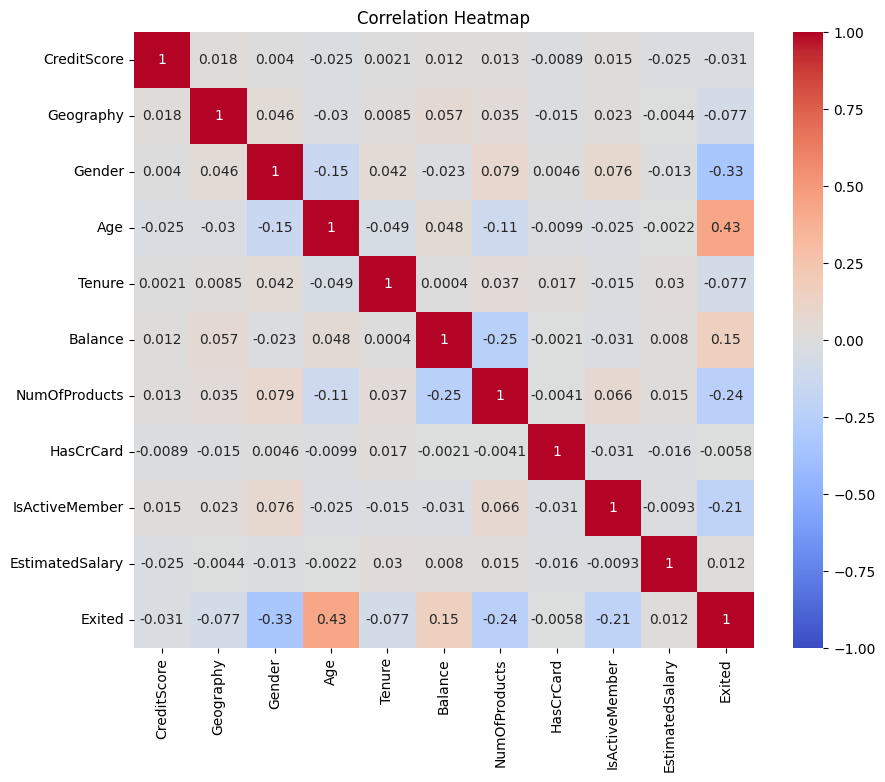

In [143]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


In [144]:
from sklearn.preprocessing import MinMaxScaler
columns_to_scale = ['CreditScore', 'Balance', 'EstimatedSalary']   # Replace with actual column names

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale selected columns
churn_df_scaled = churn_df.copy()  # Make a copy to preserve the original data
churn_df_scaled[columns_to_scale] = scaler.fit_transform(churn_df_scaled[columns_to_scale])

# Display the scaled DataFrame
print(churn_df_scaled)

       CreditScore  Geography  Gender        Age  Tenure   Balance  \
0            0.538          0       0  42.000000       2  0.000000   
1            0.516          2       0  41.000000       1  0.334031   
2            0.304          0       0  42.000000       8  0.636357   
3            0.698          0       0  39.000000       1  0.000000   
4            0.590          2       1  44.000000       8  0.453394   
...            ...        ...     ...        ...     ...       ...   
15915        0.250          0       0  44.951361       0  0.535168   
15916        0.700          1       1  62.266284       1  0.581956   
15917        0.914          0       0  47.973786       2  0.000000   
15918        0.860          1       0  52.304335       0  0.530310   
15919        0.546          0       0  38.788803       3  0.576036   

       NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0                  1   1.000000        1.000000         0.506735       1  
1        

In [145]:
X = churn_df_scaled.drop('Exited', axis=1)
y = churn_df_scaled['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier
dt_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred1 = dt_classifier.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred1))

print("Accuracy score of Decision Tree Classifier: ", accuracy_score(y_test, y_pred1))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1623
           1       0.81      0.84      0.82      1561

    accuracy                           0.83      3184
   macro avg       0.83      0.83      0.83      3184
weighted avg       0.83      0.83      0.83      3184

Accuracy score of Decision Tree Classifier:  0.8250628140703518


In [146]:
rf_classifier = RandomForestClassifier()

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred2 = rf_classifier.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred2))

print("Accuracy score of Random Forest Classifier: ", accuracy_score(y_test, y_pred2))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      1623
           1       0.90      0.85      0.88      1561

    accuracy                           0.88      3184
   macro avg       0.88      0.88      0.88      3184
weighted avg       0.88      0.88      0.88      3184

Accuracy score of Random Forest Classifier:  0.8828517587939698


In [147]:
knn_classifier = KNeighborsClassifier()

# Train the classifier
knn_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred3 = knn_classifier.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred3))

print("Accuracy score of K-Nearest Neighbors Classifier: ", accuracy_score(y_test, y_pred3))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1623
           1       0.76      0.82      0.79      1561

    accuracy                           0.78      3184
   macro avg       0.79      0.78      0.78      3184
weighted avg       0.79      0.78      0.78      3184

Accuracy score of K-Nearest Neighbors Classifier:  0.7836055276381909


In [148]:
dt_param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV with 5-fold cross-validation
dt_grid_search = GridSearchCV(estimator=dt_classifier, param_grid=dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Train the classifier with cross-validation and hyperparameter tuning
dt_grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_dt_params = dt_grid_search.best_params_
best_dt_classifier = dt_grid_search.best_estimator_

print("Best Parameters for Decision Tree: ", best_dt_params)

# Evaluate the best Decision Tree classifier
y_pred_dt = best_dt_classifier.predict(X_test)
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dt))
print("Accuracy score of Decision Tree with Hyperparameter Tuning: ", accuracy_score(y_test, y_pred_dt))

Best Parameters for Decision Tree:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5}
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1623
           1       0.83      0.80      0.82      1561

    accuracy                           0.83      3184
   macro avg       0.83      0.82      0.82      3184
weighted avg       0.83      0.83      0.82      3184

Accuracy score of Decision Tree with Hyperparameter Tuning:  0.8250628140703518


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

In [149]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize GridSearchCV with 5-fold cross-validation
knn_grid_search = GridSearchCV(estimator=knn_classifier, param_grid=knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Train the classifier with cross-validation and hyperparameter tuning
knn_grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_knn_params = knn_grid_search.best_params_
best_knn_classifier = knn_grid_search.best_estimator_

print("Best Parameters for K-Nearest Neighbors: ", best_knn_params)

# Evaluate the best KNN classifier
y_pred_knn = best_knn_classifier.predict(X_test)
print("Classification Report for K-Nearest Neighbors:")
print(classification_report(y_test, y_pred_knn))
print("Accuracy score of K-Nearest Neighbors with Hyperparameter Tuning: ", accuracy_score(y_test, y_pred_knn))


Best Parameters for K-Nearest Neighbors:  {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1623
           1       0.81      0.82      0.81      1561

    accuracy                           0.82      3184
   macro avg       0.82      0.82      0.82      3184
weighted avg       0.82      0.82      0.82      3184

Accuracy score of K-Nearest Neighbors with Hyperparameter Tuning:  0.8168969849246231


In [151]:
rf_classifier = RandomForestClassifier(random_state=42)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [30, 50, 70],      # Number of trees in the forest
    'max_depth': [None, 10, 20],       # Maximum depth of the trees
    'min_samples_split': [2, 5],       # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],         # Minimum number of samples required to be a leaf node
    'max_features': ['sqrt'],     # Number of features to consider when looking for the best split
    'criterion': ['gini', 'entropy']      # Function to measure the quality of a split
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Train the classifier with cross-validation and hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_rf_classifier = grid_search.best_estimator_

# Evaluate the classifier on the test set
y_pred_rf = best_rf_classifier.predict(X_test)

print("Best Parameters for Random Forest: ", best_params)
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy score of Random Forest with Hyperparameter Tuning: ", accuracy_score(y_test, y_pred_rf))

Best Parameters for Random Forest:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      1623
           1       0.90      0.85      0.87      1561

    accuracy                           0.88      3184
   macro avg       0.88      0.88      0.88      3184
weighted avg       0.88      0.88      0.88      3184

Accuracy score of Random Forest with Hyperparameter Tuning:  0.8800251256281407


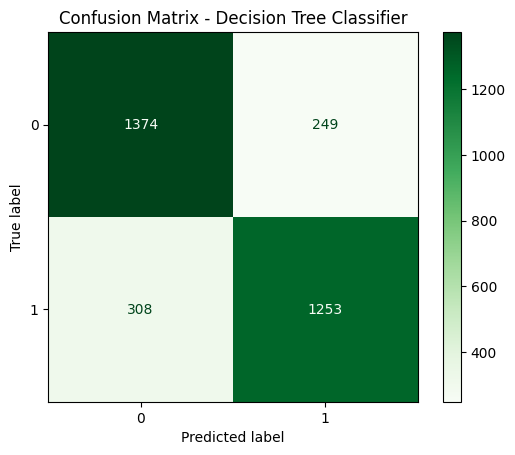

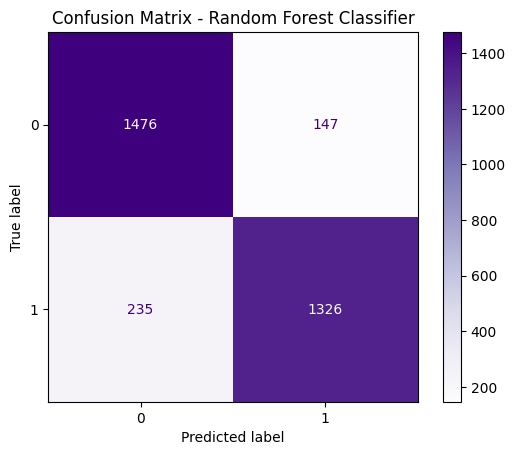

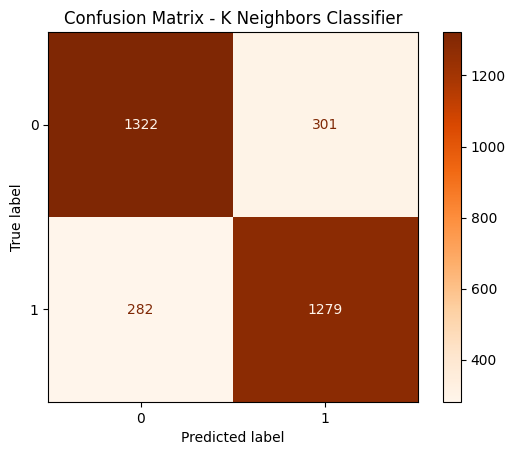

In [152]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score
import matplotlib.pyplot as plt

#Decision Tree
cm_dc = confusion_matrix(y_test,y_pred_dt)
disp_dc = ConfusionMatrixDisplay(confusion_matrix= cm_dc,display_labels=[0,1] )
disp_dc.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix - Decision Tree Classifier")
plt.show()


# Random Forest
cm_rc = confusion_matrix(y_test,y_pred_rf)
disp_rc = ConfusionMatrixDisplay(confusion_matrix= cm_rc,display_labels=[0,1] )
disp_rc.plot(cmap=plt.cm.Purples)
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

#K Neighbors Classification
cm_knn = confusion_matrix(y_test,y_pred_knn)

disp_knn = ConfusionMatrixDisplay(confusion_matrix= cm_knn,display_labels=[0,1] )
disp_knn.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix - K Neighbors Classifier")
plt.show()



In [153]:
print("Before Hypertuning: ")
print("Accuracy score of Decision Tree Classifier: ", accuracy_score(y_test,y_pred1))
print("Accuracy score of Random Forest  Classifier: ", accuracy_score(y_test,y_pred2))
print("Accuracy score of KNeighbours Classifier: ", accuracy_score(y_test,y_pred3))


print("After Hypertuning :")
print("Accuracy score of Decision Tree Classifier: ", accuracy_score(y_test,y_pred_dt))
print("Accuracy score of Random Forest Classifier: ", accuracy_score(y_test,y_pred_rf))
print("Accuracy score of K Neighbors Classifier: ", accuracy_score(y_test,y_pred_knn))

Before Hypertuning: 
Accuracy score of Decision Tree Classifier:  0.8250628140703518
Accuracy score of Random Forest  Classifier:  0.8828517587939698
Accuracy score of KNeighbours Classifier:  0.7836055276381909
After Hypertuning :
Accuracy score of Decision Tree Classifier:  0.8250628140703518
Accuracy score of Random Forest Classifier:  0.8800251256281407
Accuracy score of K Neighbors Classifier:  0.8168969849246231
